In [1]:
#hide
#skip
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [2]:
#hide
#all_slow

To use `fastai.medical.imaging` you'll need to:

```bash
conda install pyarrow
pip install pydicom kornia opencv-python scikit-image
```

To run this tutorial on Google Colab, you'll need to uncomment the following two lines and run the cell:

In [3]:
#!conda install pyarrow
#!pip install pydicom kornia opencv-python scikit-image nbdev

In [4]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom

import pandas as pd

from PIL import Image
import numpy as np
import cv2 as cv

from pydicom.uid import ExplicitVRLittleEndian


In [5]:
np.random.seed(0)

In [6]:
#hide
from nbdev.showdoc import *

# Tutorial - Binary classification of chest X-rays

> In this tutorial we will build a classifier that distinguishes between chest X-rays with pneumothorax and chest X-rays without pneumothorax. The image data is loaded directly from the DICOM source files, so no prior DICOM data handling is needed. This tutorial also goes through what DICOM images are and review at a high level how to evaluate the results of the classifier.

## Download and import of X-ray DICOM files

First, we will use the `untar_data` function to download the _siim_small_ folder containing a subset (250 DICOM files, \~30MB) of the [SIIM-ACR Pneumothorax Segmentation](https://doi.org/10.1007/s10278-019-00299-9) \[1\] dataset.
The downloaded _siim_small_ folder will be stored in your _\~/.fastai/data/_ directory. The variable `pneumothorax-source` will store the absolute path to the _siim_small_ folder as soon as the download is complete.

In [7]:
from pathlib import Path, PurePath, PurePosixPath

In [8]:
import os

In [9]:
os.getcwd()

'/home/ubuntu/fastai/nbs/WoodburnM_Calculus_CSCIE25'

In [10]:
localpath = Path('local_copy_dataset/siim_small')

In [11]:
localpath_mod = Path('mod_dataset/siim_small')

The _siim_small_ folder has the following directory/file structure:

![siim_folder_structure.jpg](../images/siim_folder_structure.jpeg)

## What are DICOMs?

**DICOM**(**D**igital **I**maging and **CO**mmunications in **M**edicine) is the de-facto standard that establishes rules that allow medical images(X-Ray, MRI, CT) and associated information to be exchanged between imaging equipment from different vendors, computers, and hospitals. The DICOM format provides a suitable means that meets health infomation exchange (HIE) standards for transmision of health related data among facilites and HL7 standards which is the messaging standard that enables clinical applications to exchange data

DICOM files typically have a `.dcm` extension and provides a means of storing data in separate ‘tags’ such as patient information as well as image/pixel data. A DICOM file consists of a header and image data sets packed into a single file. By extracting data from these tags one can access important information regarding the patient demographics, study parameters, etc.

16 bit DICOM images have values ranging from `-32768` to `32768` while 8-bit greyscale images store values from `0` to `255`. The value ranges in DICOM images are useful as they correlate with the [Hounsfield Scale](https://en.wikipedia.org/wiki/Hounsfield_scale) which is a quantitative scale for describing radiodensity

### Plotting the DICOM data

In [12]:
items = get_dicom_files(localpath/f"train/")

Next, we split the `items` list into a train `trn` and validation `val` list using the `RandomSplitter` function:

In [13]:
df = pd.read_csv(localpath/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


In [15]:
len(df)

250

In [16]:
calculus_files = np.random.choice(df['file'].values, int(len(df)*0.2), replace = False)

In [24]:
def modify_dicom(DICOM_filename):

    xray_sample = DICOM_filename.dcmread()

    img = Image.fromarray(xray_sample.pixel_array)

    x = int((img.shape[1]*0.5+ np.random.rand(1)*img.shape[1]*0.1).item())
    y = int((img.shape[0]*0.3+ np.random.rand(1)*img.shape[1]*0.1).item())

    img = cv.circle(xray_sample.pixel_array, (x,y), 50, 255, -1)

    xray_sample.PixelData = xray_sample.pixel_array.tostring()

    xray_sample.file_meta.TransferSyntaxUID = ExplicitVRLittleEndian

    xray_end_path = PurePosixPath(*DICOM_filename.parts[2:])

    save_path = localpath_mod / xray_end_path

    save_path.parent.mkdir(parents=True, exist_ok=True)

    xray_sample.save_as(save_path)

In [26]:
for file in calculus_files:
    DICOM_filename =  localpath/file
    modify_dicom(DICOM_filename)
    

/tmp/ipykernel_2147/2708883587.py:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  xray_sample.PixelData = xray_sample.pixel_array.tostring()


In [31]:
DICOM_filename

Path('local_copy_dataset/siim_small/train/No Pneumothorax/000179.dcm')

In [34]:
DICOM_mod_filename = Path('mod_dataset/siim_small/train/No Pneumothorax/000179.dcm')

In [36]:
img = DICOM_mod_filename.dcmread()

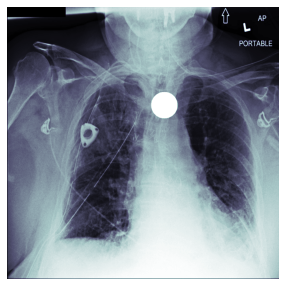

In [37]:
img.show()

In [38]:
df.loc[df['file'].isin(calculus_files), ['calculus']] = True

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax
...,...,...
245,train/No Pneumothorax/000245.dcm,No Pneumothorax
246,train/No Pneumothorax/000246.dcm,No Pneumothorax
247,train/Pneumothorax/000247.dcm,Pneumothorax
248,train/No Pneumothorax/000248.dcm,No Pneumothorax


In [42]:
df.loc[df['file'].isin(calculus_files), ['calculus']] = True

In [49]:
df['calculus'] = df['calculus'].fillna(False)

In [58]:
no_calculus_files = df.loc[~df['file'].isin(calculus_files),'file'].values

In [59]:
def do_not_modify_dicom(DICOM_filename):

    xray_sample = DICOM_filename.dcmread()

    img = Image.fromarray(xray_sample.pixel_array)

    xray_sample.PixelData = xray_sample.pixel_array.tostring()

    xray_sample.file_meta.TransferSyntaxUID = ExplicitVRLittleEndian

    xray_end_path = PurePosixPath(*DICOM_filename.parts[2:])

    save_path = localpath_mod / xray_end_path

    save_path.parent.mkdir(parents=True, exist_ok=True)

    xray_sample.save_as(save_path)

In [60]:
for file in no_calculus_files:
    DICOM_filename =  localpath/file
    do_not_modify_dicom(DICOM_filename)
    

/tmp/ipykernel_2147/2764492987.py:7: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  xray_sample.PixelData = xray_sample.pixel_array.tostring()


In [61]:
localpath

Path('local_copy_dataset/siim_small')

In [67]:
df.to_csv(localpath_mod/'labels.csv', index = False)